In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
train_list = list(filter(lambda x: (str(x)[-1] in ['1', '5']), range(1, 201)))
test_list = list(filter(lambda x: (str(x)[-1] not in ['1', '5']), range(1, 201)))

In [3]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
import glob
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path
import pyximport; pyximport.install()
import multiprocessing
import math
import time
import librosa
import csv

In [4]:
### system parameters ###
dtw_steps = [1,1,1,2,2,1] # dtw
dtw_weights = [1,1,2]
##########################

In [5]:
def loadMidiBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    miditimes = d['times']
    num_notes = np.array(d['num_notes'])
    stafflines = d['stafflines']
    return bscore, miditimes, num_notes, stafflines

In [6]:
def loadSheetBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    events = d['events']
    return bscore, events

In [7]:
def costMetric(X,Y):
    cost = -1 * np.dot(X,Y)
    return cost

In [8]:
def normalizedCostMetric(Q, R, numQueryNotes, numRefNotes):
    cost = -1 * np.matmul(Q.T, R)
    query_norm_factor = repmat(numQueryNotes.reshape((-1,1)), 1, R.shape[1])
    ref_norm_factor = repmat(numRefNotes.reshape((1,-1)), Q.shape[1], 1)
    norm_factor = np.maximum(query_norm_factor, ref_norm_factor) + 1e-8 # avoid divide by 0
    norm_cost = cost / norm_factor
    return norm_cost

In [9]:
def alignBootlegScores(query, ref, numRefNotes, steps = [1,1,1,2,2,1], weights = [1,1,2], optimized=True):
    if optimized: # Cython implementation
        # set params
        assert len(steps) % 2 == 0, "The length of steps must be even."
        dn = np.array(steps[::2], dtype=np.uint32)
        dm = np.array(steps[1::2], dtype=np.uint32)
        dw = weights
        subsequence = True
        parameter = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': subsequence}

        # Compute cost matrix
        #cost = costMetric(query.T, ref)
        numQueryNotes = np.sum(query, axis=0)
        cost = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)

        # DTW
        [D, s] = DTW_Cost_To_AccumCostAndSteps(cost, parameter)
        [wp, endCol, endCost] = DTW_GetPath(D, s, parameter)

        # Reformat the output
        wp = wp.T[::-1]
    else: # librosa implementation
        steps = np.array(steps).reshape((-1,2))
        D, wp = lb.sequence.dtw(query, ref, step_sizes_sigma = steps, weights_mul = weights, subseq = True, metric = costMetric)
    return D, wp

In [10]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [11]:
def plotAlignment(D, wp, seginfo = None):
    plt.figure(figsize = (10,10))
    plt.imshow(D, origin = 'lower', cmap = 'jet')
    plt.plot(wp[:,1], wp[:,0], color='y')
    plt.xlabel('Ref')
    plt.ylabel('Query')
    if seginfo is not None:
        #matchSegTime, refSegTimes, refSegCols = seginfo
        refSegCols = seginfo
        for i, refSegCol in enumerate(refSegCols):            
            plt.axvline(refSegCol[0], color = 'm')
            plt.axvline(refSegCol[1], color = 'm')
        #plt.title('Hyp ({:.1f} s, {:.1f} s), Ref ({:.1f} s, {:.1f} s)'.format(matchSegTime[0], matchSegTime[1], refSegTimes[0][0], refSegTimes[0][1]))
    else:
        plt.title('Subsequence DTW Alignment')

In [12]:
def getPredictedLineInfo(wp):
    startEvent = wp[-1, -1]
    startPage = events[startEvent][5]
    startLine = events[startEvent][2] + 1
    endEvent = wp[0, -1]
    endPage = events[endEvent][5]
    endLine = events[endEvent][2] + 1
    return ([startPage, endPage], [startLine, endLine])

In [13]:
def getGroundTruthLineInfo(imagefile):
    pages = []
    lines = []
    with open('/home/mshan/ttemp/data/timeAnnot/' + imagefile + '.timeannot.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            page = row[0].split('L')[0][1:]
            pages.append(int(page))
            line = row[0].split('L')[1]
            lines.append(int(line))
    return ([pages[0], pages[-1]], [lines[0], lines[-1]])

In [16]:
piece = 154
midi_pkl_dir = '/home/mshan/ttemp/data/bscore/0/p{}.pkl'.format(piece)
sheet_pkl_dir = '/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(piece)
piece_dir = '/home/mshan/ttemp/data/png/p{}'.format(piece)

In [17]:
bscore_midi, miditimes, _, stafflines = loadMidiBootlegScore(midi_pkl_dir)
bscore_sheet, events = loadSheetBootlegScore(sheet_pkl_dir)
num_notes = np.asarray([len(event[0]) for event in events])

Predicted page range: [1, 2] Predicted line range: [2, 2]
Correct page range: [1, 2] Correct line range: [1, 4]


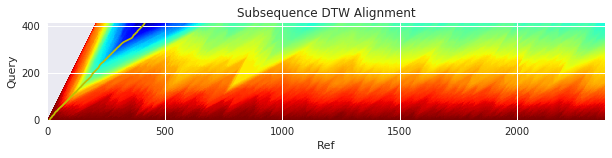

In [18]:
D, wp = alignBootlegScores(bscore_midi, bscore_sheet, num_notes, dtw_steps, dtw_weights)
matchSegmentPage, matchSegmentLine = getPredictedLineInfo(wp)
print("Predicted page range: " + str(matchSegmentPage), "Predicted line range: " + str(matchSegmentLine))
refSegmentPage, refSegmentLine = getGroundTruthLineInfo('p{}'.format(piece))
print("Correct page range: " + str(refSegmentPage), "Correct line range: " + str(refSegmentLine))
refEvents = []
for i, event in enumerate(events):
    if event[-1] in refSegmentPage:
        refEvents.append(i)
plotAlignment(D, wp)

### Align

In [16]:
def alignPiece(piece, data='data'):
    bscore_midi, miditimes, _, stafflines = loadMidiBootlegScore('/home/mshan/ttemp/{}/bscore/p{}.pkl' .format(data, piece))
    bscore_sheet, events = loadSheetBootlegScore('/home/mshan/ttemp/{}/bscore_sheet/p{}.pkl'.format(data, piece))
    num_notes = np.asarray([len(event[0]) for event in events])
    if num_notes.shape[0] != bscore_sheet.shape[1]:
        bscore_sheet = bscore_sheet[:, 1:]   
    D, wp = alignBootlegScores(bscore_midi, bscore_sheet, num_notes, dtw_steps, dtw_weights)
    wp = wp[::-1]
    times = [miditime[0] for miditime in miditimes]
    midi_frame = [time_point[0] for time_point in wp]
    actual_time = [times[k] for k in midi_frame]
     
    d = {}
    d['events'] = events
    d['actual_time'] = actual_time
    d['wp'] = wp
    with open('/home/mshan/ttemp/data/hyp/subseqDTW/{}/p{}.pkl'.format(data, piece), 'wb') as f:
        pickle.dump(d, f)

In [29]:
for i in [99, 109, 117, 120, 139, 172, 179, 186]:
    for data in ['data', 'data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']:
        alignPiece(i, data=data)

A path is not possible
A path is not possible
A path is not possible
A path is not possible
A path is not possible
A path is not possible
A path is not possible


### Decide the tolerance

In [419]:
tol = range(0,161,10)
res = [0.028613116176562956, 0.6468402900738537, 0.795491114998979, 0.8093670018377619, 0.8113906046759265, 0.8113906046759265, 0.8113906046759265, 0.8113906046759265, 0.8113906046759265, 0.8123558034682697, 0.8123558034682697, 0.8123558034682697, 0.8123558034682697, 0.8083164174063567, 0.796601598125594, 0.7776486651554321
, 0.7571104661067255]

Text(0, 0.5, 'accuracy')

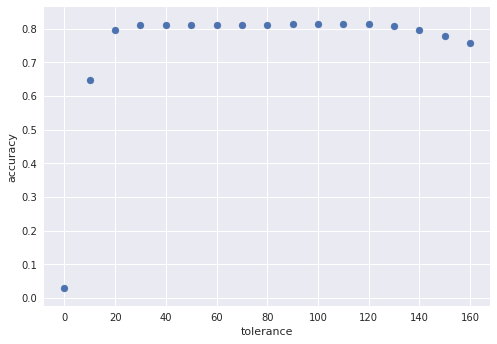

In [420]:
plt.scatter(tol,res)
plt.xlabel('tolerance')
plt.ylabel('accuracy')